# Gl 357b TTV estimation

This notebook carries out the TTV analysis of Gl 357 (TOI 562.01) described by R. Luque et al. (submitted to A&A 2019, [arXiv:1904.12818](https://arxiv.org/abs/1904.12818)). 

**Data:** The data consists of five 4.8-hour chunks of TESS PDCSAP flux centred around the transit centres expected based on the linear ephemeris.

**Model:** The model represents the light curve around each transit with a transit model multiplied by a baseline model made of Legendre polynomials. Each transit has its own transit centre and a set of Legendre polynomial coefficients, and the rest of the parameters defining the planet and its orbit are shared.



In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pyopencl as cl
import seaborn as sb

from pathlib import Path
from corner import corner
from pytransit.param.parameter import LParameter, UniformPrior as UP, NormalPrior as NP

In [3]:
dfile = Path('data/tess2019032160000-s0008-0000000413248763-0136-s_lc.fits')
zero_epoch   = 2458517.999665
period       = 3.930792
nlegendre    = 5
npop         = 100
mcmc_repeats = 4

## Setup OpenCL

Here I set OpenCL to use the third device in my MacBook Pro (AMD Radeon Pro 560X). 

**This needs to be customised for your GPU!**

In [4]:
dev = cl.get_platforms()[0].get_devices()[2:]
ctx = cl.Context(dev)

or you can also use the default context, which can be set via the `PYOPENCL_CTX` environment value.

In [5]:
# ctx = cl.create_some_context()

In [6]:
queue = cl.CommandQueue(ctx)

## Define the log posterior function

Here I'm cheating a bit to make the notebook easier to read. I define a `TESSTTVLPF` log posterior function class in `src/lpf.py`, which subclasses a generic OpenCL TTV log posterior class `pytransit.lpf.OCLTTVLPF`. The log posterior function class implements posterior optimisation and MCMC sampling, and everything else required for TTV estimation.

In [7]:
%run src/lpf.py

## Create the Log Posterior function

### Initialise the log posterior function and override the default priors.

In [8]:
lpf = TESSTTVLPF('Gl_357b', dfile, zero_epoch, period, 
                 nsamples=5, bldur=0.2, nlegendre=nlegendre, 
                 ctx=ctx, queue=queue)

lpf.set_prior(7, UP(0.01**2, 0.05**2))                            # Uniform prior on the area ratio
for i,tn in enumerate(lpf.tnumber):                               # Wide normal priors on transit centres:
    lpf.set_prior(2+i, NP(lpf.zero_epoch + tn*lpf.period, 0.02))  #   - based on the linear ephemeris

### Print the model parameters

In [9]:
for i,p in enumerate(lpf.ps):
      print(p.__repr__(), end=('\t' if i%2 == 0 else '\n'))

  0 |G| rho        [0.00 ..  inf]	  1 |G| b          [0.00 .. 1.00]
  2 |G| tc_0       [-inf ..  inf]	  3 |G| tc_1       [-inf ..  inf]
  4 |G| tc_2       [-inf ..  inf]	  5 |G| tc_5       [-inf ..  inf]
  6 |G| tc_6       [-inf ..  inf]	  7 |P| k2         [0.00 .. 0.30]
  8 |P| q1_0       [0.00 .. 1.00]	  9 |P| q2_0       [0.00 .. 1.00]
 10 |L| bli_0      [0.98 .. 1.02]	 11 |L| bls_0_1    [-0.10 .. 0.10]
 12 |L| bls_0_2    [-0.10 .. 0.10]	 13 |L| bls_0_3    [-0.10 .. 0.10]
 14 |L| bls_0_4    [-0.10 .. 0.10]	 15 |L| bls_0_5    [-0.10 .. 0.10]
 16 |L| bli_1      [0.98 .. 1.02]	 17 |L| bls_1_1    [-0.10 .. 0.10]
 18 |L| bls_1_2    [-0.10 .. 0.10]	 19 |L| bls_1_3    [-0.10 .. 0.10]
 20 |L| bls_1_4    [-0.10 .. 0.10]	 21 |L| bls_1_5    [-0.10 .. 0.10]
 22 |L| bli_2      [0.98 .. 1.02]	 23 |L| bls_2_1    [-0.10 .. 0.10]
 24 |L| bls_2_2    [-0.10 .. 0.10]	 25 |L| bls_2_3    [-0.10 .. 0.10]
 26 |L| bls_2_4    [-0.10 .. 0.10]	 27 |L| bls_2_5    [-0.10 .. 0.10]
 28 |L| bli_5      [0.98 .. 1.02]

## Global optimisation

We'll start with a global optimisation run to clump the parameter vector population near the global posterior mode and plot the mode.

**Note:** The parameter vector population size `npop` should be at least twice the number of free parameters (`len(lpf.ps)`).

**Performance:** With `npop = 100`, the optimisation speed should be 180-200 it/sec running on a normal laptop GPU.

In [10]:
lpf.optimize_global(5000, npop=npop)

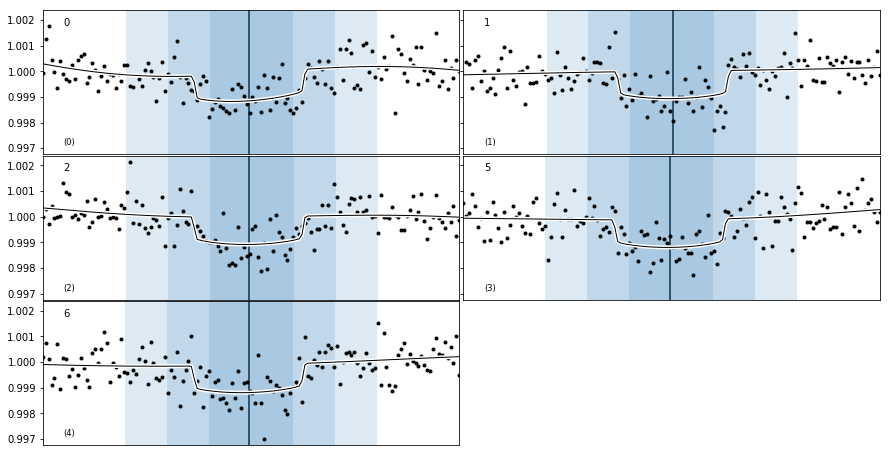

In [11]:
lpf.plot_transits(2, figsize=(15,8))

## MCMC

### Sample the posterior
We continue with an MCMC run, using the global optimisation population as the MCMC starting population. The MCMC sampling consists of a set of wamp-up runs where each run is started from the parameter vector population of the previous run's last iteration, and the chains from the previous run are discarded.

In [12]:
for i in range(mcmc_repeats):
    lpf.sample_mcmc(2000, reset=(i > 0))

### Plot the chain distributions

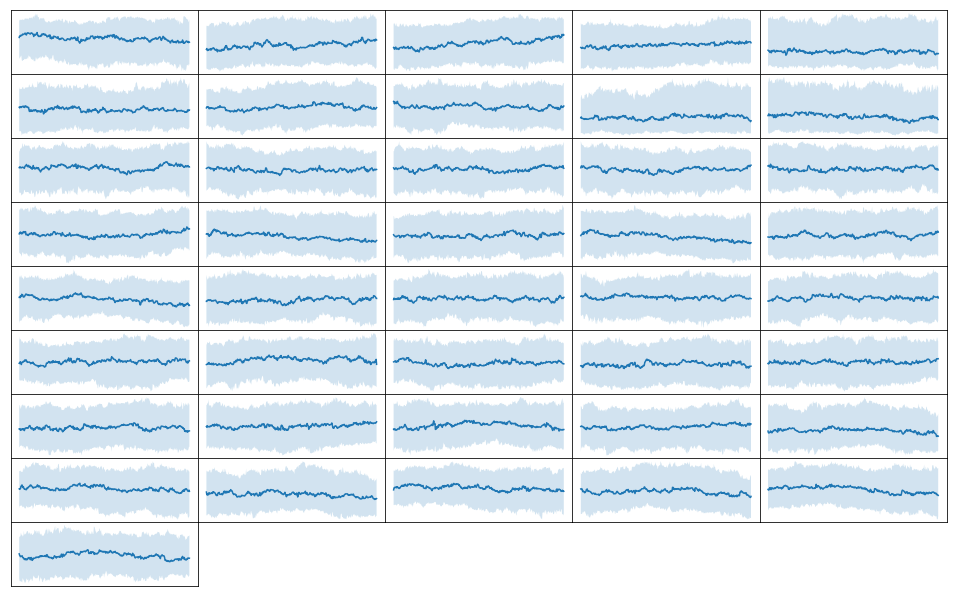

In [13]:
npar = len(lpf.ps)
ncols = 5
nrows = int(ceil(npar/ncols))

pes = percentile(lpf.sampler.chain, [50, 16, 84], axis=0)

fig, axs = subplots(nrows, ncols, figsize=(13,8), sharex='all',
                    gridspec_kw=dict(hspace=0, wspace=0, left=0, right=1, bottom=0, top=1))
x = arange(pes.shape[1])
for i in range(npar):
    axs.flat[i].fill_between(x, pes[1,:,i], pes[2,:,i], alpha=0.2)
    axs.flat[i].plot(x,pes[0,:,i])
setp(axs, yticks=[], xticks=[]);
setp(axs.flat[-4:], visible=False);

### Plot the posterior model

In [14]:
df = lpf.posterior_samples(include_ldc=True)
df['err'] = 10**df.log_err
df['k'] = sqrt(df.k2)
pvp = permutation(df.values)[:5000]
pv = df.median()
tmodels = lpf.flux_model(pvp)
mm = percentile(tmodels, [50, 16, 84, 0.5, 99.5], 0)

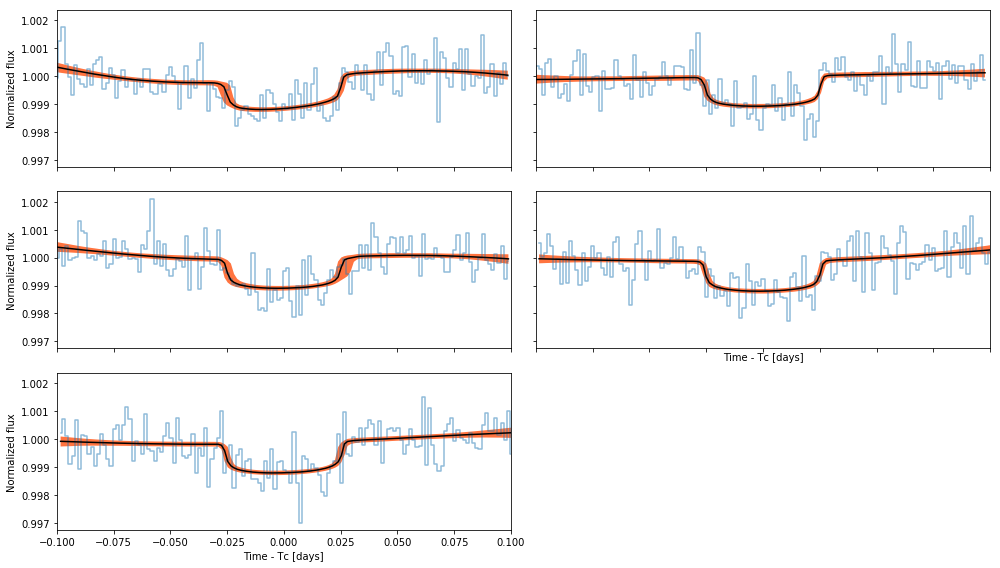

In [15]:
fig, axs = subplots(3,2, figsize=(14,8), sharey=True, sharex='all')
for i, sl in enumerate(lpf.lcslices):
    axs.flat[i].plot(lpf.times[i]-pv[2+i], lpf.fluxes[i], drawstyle='steps-mid', alpha=0.5)
    axs.flat[i].plot(lpf.times[i]-pv[2+i], mm[0][sl], 'k')
    axs.flat[i].fill_between(lpf.times[i]-pv[2+i], mm[1][sl], mm[2][sl], alpha=0.75, facecolor='orangered')
    setp(axs[:,0], ylabel='Normalized flux')
    setp(axs.flat[[3,4]], xlabel='Time - Tc [days]')
    setp(axs, xlim=(-0.1,0.1))
    setp(axs[2,1], visible=False)
fig.tight_layout()
fig.savefig('Gl_357b_lcs.pdf')

### The default corner plot

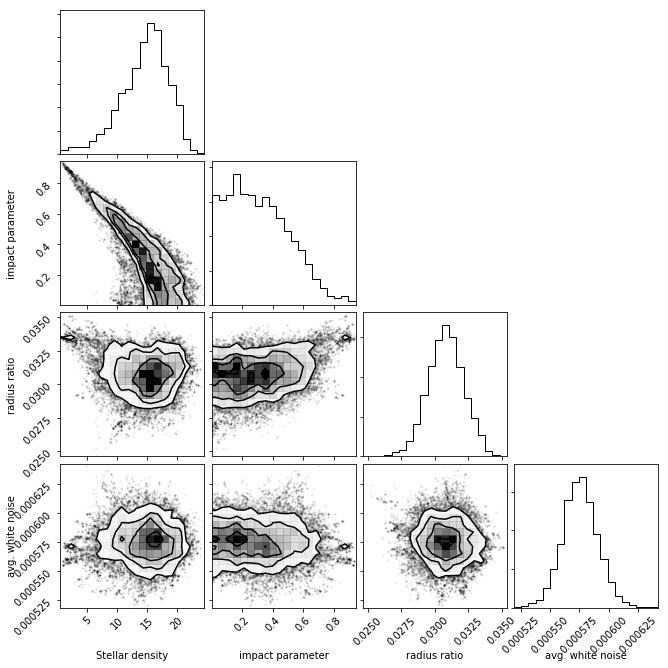

In [16]:
corner(df['rho b k err'.split()], 
       labels='Stellar density, impact parameter, radius ratio, avg. white noise'.split(', '));

### Plot the TTV posterior estimates

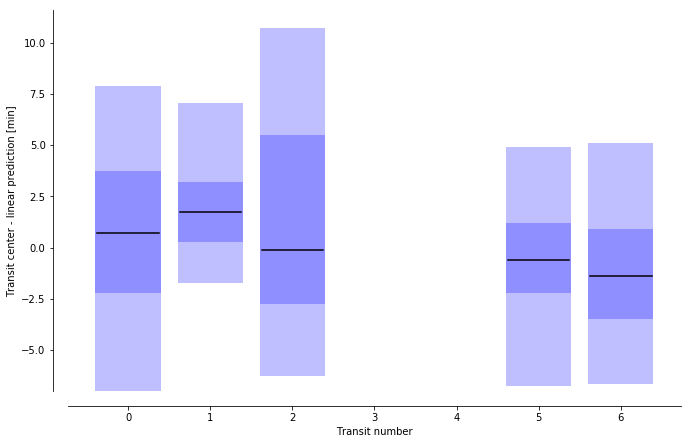

In [17]:
fig, ax = subplots(figsize=(11,7))
lpf.plot_ttvs(axs=ax, fmt='min');
fig.savefig('Gl_357b_ttv.pdf')

----
<center> © 2019 Hannu Parviainen </center>